In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models

In [2]:
train_feat = np.load("datasets/train/train_feature.npz", allow_pickle=True)
train_feat_X = train_feat['features']
train_feat_Y = train_feat['label']

valid_feat = np.load("datasets/valid/valid_feature.npz", allow_pickle=True)
valid_feat_X = valid_feat['features']
valid_feat_Y = valid_feat['label']

test_feat = np.load("datasets/test/test_feature.npz", allow_pickle=True)
test_feat_X = test_feat['features']

In [3]:
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]

def evaluate_decision_tree(train_feat_X_method, valid_feat_X_method, method_name):
    accuracies = []
    for percentage in percentages:
        n_samples = int(len(train_feat_X_method) * percentage)
        
        x_train_subset = train_feat_X_method[:n_samples]
        y_train_subset = train_feat_Y[:n_samples]
        
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train_subset)
        x_valid_scaled = scaler.transform(valid_feat_X_method)

        dt_classifier = DecisionTreeClassifier(random_state=42)
        dt_classifier.fit(x_train_scaled, y_train_subset)

        y_pred = dt_classifier.predict(x_valid_scaled)

        accuracy = accuracy_score(valid_feat_Y, y_pred)
        accuracies.append(accuracy)
    
    return accuracies

In [4]:
# 1. Averaging Embeddings
train_feat_X_avg = np.mean(train_feat_X, axis=1)
valid_feat_X_avg = np.mean(valid_feat_X, axis=1)
accuracies_avg = evaluate_decision_tree(train_feat_X_avg, valid_feat_X_avg, "Averaging")

# 2. Concatenation of Embeddings
train_feat_X_concat = train_feat_X.reshape(train_feat_X.shape[0], -1)
valid_feat_X_concat = valid_feat_X.reshape(valid_feat_X.shape[0], -1)
accuracies_concat = evaluate_decision_tree(train_feat_X_concat, valid_feat_X_concat, "Concatenation")

# 3. MaxPooling of Embeddings
train_feat_X_maxpool = np.max(train_feat_X, axis=1)
valid_feat_X_maxpool = np.max(valid_feat_X, axis=1)
accuracies_maxpool = evaluate_decision_tree(train_feat_X_maxpool, valid_feat_X_maxpool, "MaxPooling")

# 4. CNN-based Embedding Extraction
def build_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(13, 768)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    return model

cnn_model = build_cnn_model()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Get CNN features
train_feat_cnn = cnn_model.predict(train_feat_X)
valid_feat_cnn = cnn_model.predict(valid_feat_X)
accuracies_cnn = evaluate_decision_tree(train_feat_cnn, valid_feat_cnn, "CNN")

 45/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

c:\python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


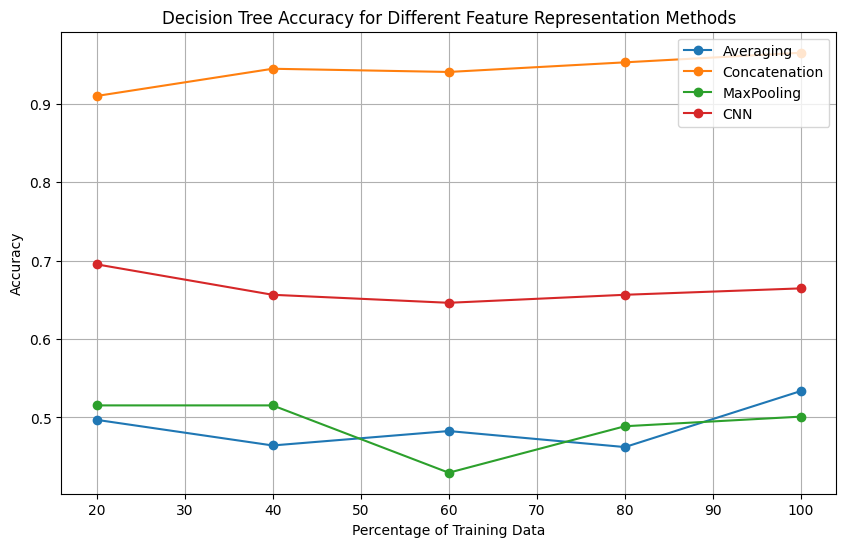

In [5]:
plt.figure(figsize=(10, 6))
plt.plot([p * 100 for p in percentages], accuracies_avg, label="Averaging", marker='o')
plt.plot([p * 100 for p in percentages], accuracies_concat, label="Concatenation", marker='o')
plt.plot([p * 100 for p in percentages], accuracies_maxpool, label="MaxPooling", marker='o')
plt.plot([p * 100 for p in percentages], accuracies_cnn, label="CNN", marker='o')

plt.xlabel("Percentage of Training Data")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy for Different Feature Representation Methods")
plt.legend()
plt.grid(True)
plt.show()